### Regressie op een subset van de ames housing
In this notebook we work on regression. We are using a subset of the ames housing dataset (7 variables) with missing values. 

We assume that the target variable is SalePrice and we perform a regression analysis using the other 6 variables that we call independent variables and SalePrice that we refer to in this notebook as the dependent or the target variable.

# Table of content

 1. Loading data
 2. Prepare the data
 3. Regression analysis:
    - 3.1 Assess the relationship between SalePrice and the independent variables?
    - 3.2 Linear regression with multiple predictors
    - 3.3 Tuning the regression model 
    - 3.4 Which other regression models can be more efficient than linear regression for our dataset? 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import category_encoders as ce
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FunctionTransformer

import h2o
from h2o.automl import H2OAutoML


#### 1. Loading data

In [3]:
ames_housing_subset = pd.read_csv("ames_housing_subset.csv")
ames_housing_subset

,GrLivArea,LotShape,ExterQual,OverallQual,Neighborhood,TotRmsAbvGrd,SalePrice
0,1710.0,Reg,Gd,7,CollgCr,8,208500
1,1262.0,Reg,TA,6,Veenker,6,181500
2,1786.0,IR1,Gd,7,CollgCr,6,223500
3,1717.0,IR1,TA,7,Crawfor,7,140000
4,2198.0,IR1,Gd,8,NoRidge,9,250000
...,...,...,...,...,...,...,...
1455,1647.0,Reg,TA,6,Gilbert,7,175000
1456,2073.0,Reg,TA,6,NWAmes,7,210000
1457,2340.0,Reg,Ex,7,Crawfor,9,266500
1458,1078.0,Reg,TA,5,NAmes,5,142125


In [4]:
ames_housing_subset.columns

Index(['GrLivArea', 'LotShape', 'ExterQual', 'OverallQual', 'Neighborhood',
       'TotRmsAbvGrd', 'SalePrice'],
      dtype='object')

In [5]:
ames_housing_subset['ExterQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In the verkenende analyse part you have explored the data and made few conlusions that we are going to use as input for this regression part:
- The subset has 4 categorical variables: "LotShape", "ExterQual", "OverallQual", "Neighborhood" and 2 numerical variables "GrLivArea", "TotRmsAbvGrd", "SalePrice"
- Both "GrLivArea" and "Neighborhood" have missing values.

In the verkennende analyse opdracht, we have made also some assumptions regarding outliers and normal distribution of both numerical and categorical variables in our subset:
- The 2 continuous variables (SalePrice and GrLivArea) are not normally distributed.
- The frequency of the categorical variables both nominal (LotShape, ExterQual and Neighborhood) and ordinal (OverallQual and TotRmsAbvGrd )is not balanced.
- SalePrice, GrLivArea, Neighborhood have outliers 

In this regression part we will be busy preparing the data for further regression by dealing with:
- missing values
- no normal and not scaled data
- data with outliers

#### 1. Does the data contain missing values

In [6]:
ames_housing_subset.isnull().sum()

GrLivArea       25
LotShape         0
ExterQual        0
OverallQual      0
Neighborhood    12
TotRmsAbvGrd     0
SalePrice        0
dtype: int64

Before looking closely into our variables, let's store numerical and categorical data in separate variables. That helps to deal with the variable based on datatypes.

#### 1. Distinguish numerical and categorical variables

In [7]:
X = ames_housing_subset.drop(columns="SalePrice")
y = ames_housing_subset["SalePrice"]

In [8]:
cat_vars = ["LotShape", "ExterQual", "Neighborhood"]
cont_vars = ["GrLivArea"]
num_ordi_var = ["OverallQual", "TotRmsAbvGrd"]

#### 2. Prepare the data

Based on the information we gathered during de verkennende analyse part, we know how the data looks like:
- Categorical variables are encoded as string values
- Both continuous and categorical variables contain outliers
- Data is not normally distribueted
- Continuous variables have different scales
- The data has missing values 


We perform the preparation steps using a pipeline with custom BaseEstimator/TransformerMixin classes as this might help structure our code in a more organized and efficient way. We include in our pipeline the following aspects:
- Impute missing values in GrLivArea with median and those in Neighborhood with mode 
- Tranform classes in categorical variables to numerical values. Since many machine learning algoithms assume that data is in numerical data encoded or can not deal with strings. This is also the case of the LinearRegression algorithm we will use in the regression analysis part. In our data, "LotShape", "ExterQual" and "Neighborhood". Based on the nature of each categorical variable, we use different encoding approaches:
  - "Neighborhood" are nominal categorical variables where the order of categories is not important, we choose a target encoding as it helps avoid assuming order of categories that does not exist. 
  - "ExterQual" is ordinal where the values are encoded as strings:Ex (Excellent), Gd (Good), TA (Average/Typical), Fa (Fair), and Po (Poor). In that case we chose to map categories (string) to integers.
- "OverallQual", "LotShape" and TotRmsAbvGrd are ordinal variables where the values are encoded as integers.
- scale only numerical variables (GrLivArea): Given that our data contains outliers, we opt for scaling with Robust scaler from the sklearn.preprocessing as it is more robust to outliers compared to MinMaxScaler. 
- We do not prepare the SalePrice  

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.target_enc = ce.TargetEncoder(cols=self.cols)

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.cols)  # ensure X is a DataFrame
        self.target_enc.fit(X[self.cols], y)
        return self

    def transform(self, X):
        X = X.copy()
        X = pd.DataFrame(X, columns=self.cols)  # ensure X is a DataFrame
        X[self.cols] = self.target_enc.transform(X[self.cols])
        return X



class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col_mapping=None):
        self.col_mapping = col_mapping or {}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.col_mapping.keys())  # Convert array to DataFrame with named columns
        for col, mapping in self.col_mapping.items():
            X[col] = X[col].map(mapping)
        return X.values  # Convert back to array for downstream compatibility



In [10]:
type(cat_vars)

list

In [11]:
# pipeline for categorical data
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


# target encoder for certain categorical features
target_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # add an imputer before target encoding
    ('target_enc', TargetEncoder(cols=['Neighborhood']))
])

ordinal_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # add an imputer before ordinal encoding
    ('ExterQual_ordinal', OrdinalEncoder(col_mapping={
        'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},  # swapped the order of 'LotShape' and 'ExterQual'
        'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    }))
])


# pipeline for numerical data
cont_preprocessor = Pipeline(steps=[
    ('num_imputer',SimpleImputer(strategy="median")), 
    ('scaler', RobustScaler())
    ])

num_ord_preprocessor = Pipeline(steps=[
    ('numerical_ordinal_imputer', SimpleImputer(strategy='most_frequent'))
    ])

# We'll use ColumnTransformer to put together these preprocessing steps for different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous_vars', cont_preprocessor, cont_vars),
        ('numerical_ordinal_vars', num_ord_preprocessor, num_ordi_var),
        ('categorical_nominal', target_encoder, ['Neighborhood']),
        ('categorical_ordinal', ordinal_encoder, ['LotShape', 'ExterQual'])
    ])

In [12]:
prep_pipline = Pipeline([
        ("preprocess", preprocessor)
])

In [13]:
X_prep = prep_pipline.fit_transform(X, y)

The output of the pipeline is a numpy array, we convert X_prep back to a pandas dataframe as it is the form that we will need for our regression analysis.
Since the order of columns in our dataframe follows the order in which the columns have been processed in the pipeline, we make sure that we set column names in a way that matches that processing order.

In [14]:
transformer_names = cont_vars + num_ordi_var + ['Neighborhood'] + ['LotShape','ExterQual']
X_prep_df = pd.DataFrame(X_prep, columns=transformer_names)

X_prep_df

,GrLivArea,OverallQual,TotRmsAbvGrd,Neighborhood,LotShape,ExterQual
0,0.383046,7.0,8.0,198086.306114,1.0,4.0
1,-0.320251,6.0,6.0,197643.209810,1.0,3.0
2,0.502355,7.0,6.0,198086.306114,2.0,4.0
3,0.394035,7.0,7.0,209344.287867,2.0,3.0
4,1.149137,8.0,9.0,318453.591177,2.0,4.0
...,...,...,...,...,...,...
1455,0.284144,6.0,7.0,193059.481445,1.0,3.0
1456,0.952904,6.0,7.0,189268.194969,1.0,3.0
1457,1.372057,7.0,9.0,209344.287867,1.0,5.0
1458,-0.609105,5.0,5.0,147882.504251,1.0,3.0


Note that we, in our first preprocessing scenario, scaled only GrLivArea as it is our continous variables.
Now let's perform a regression analysis using the new prepared data issued from our preprocessing steps.

test linear model with different preprocessing scenarios:
- scale also OverallQual and TotRmsAbvGrd. At the beginning we scaled only the continuous variable (GrLivArea)
- use onehot-encoding to encode nominal categories like Neighborhood.
- use ordinal-encoding to encode ordinal categories like ExterQual and LotShape


#### 3. Regression analysis 

We perform regression analysis following this structure:
- Analyze the relationship between the dependent variable and the independent variables
- Implement simple linear regression with one predictor
- Implement multiple linear regression with multiple predictors 
- Implement other regression models and compare their results



#### 3.1. Assess the relationship between SalePrice and the independent variables?

We assume that SalePrice is our dependent variable.

As you have seen in de verkenende analyse opdracht, SalePrice is correlated with GrLivArea, OverallQual, Loshape, ExterQual, TotRmsAbvGrd and Neighborhood. So we assume that there exist a correlation between the dependent variable and independent ones.

In the following analysis, we are focusing more on proving the following assumptions:
1. Assessing that relationship between the depedent variable and the independent variables is linear
2. Checking the stength of the relationship
3. normality of risiduals   



Now let's check again the relationship between SalePrice and the other independent variables. The best way to do it is by using regplot (that is a plot you already used for the verkennende analyse).

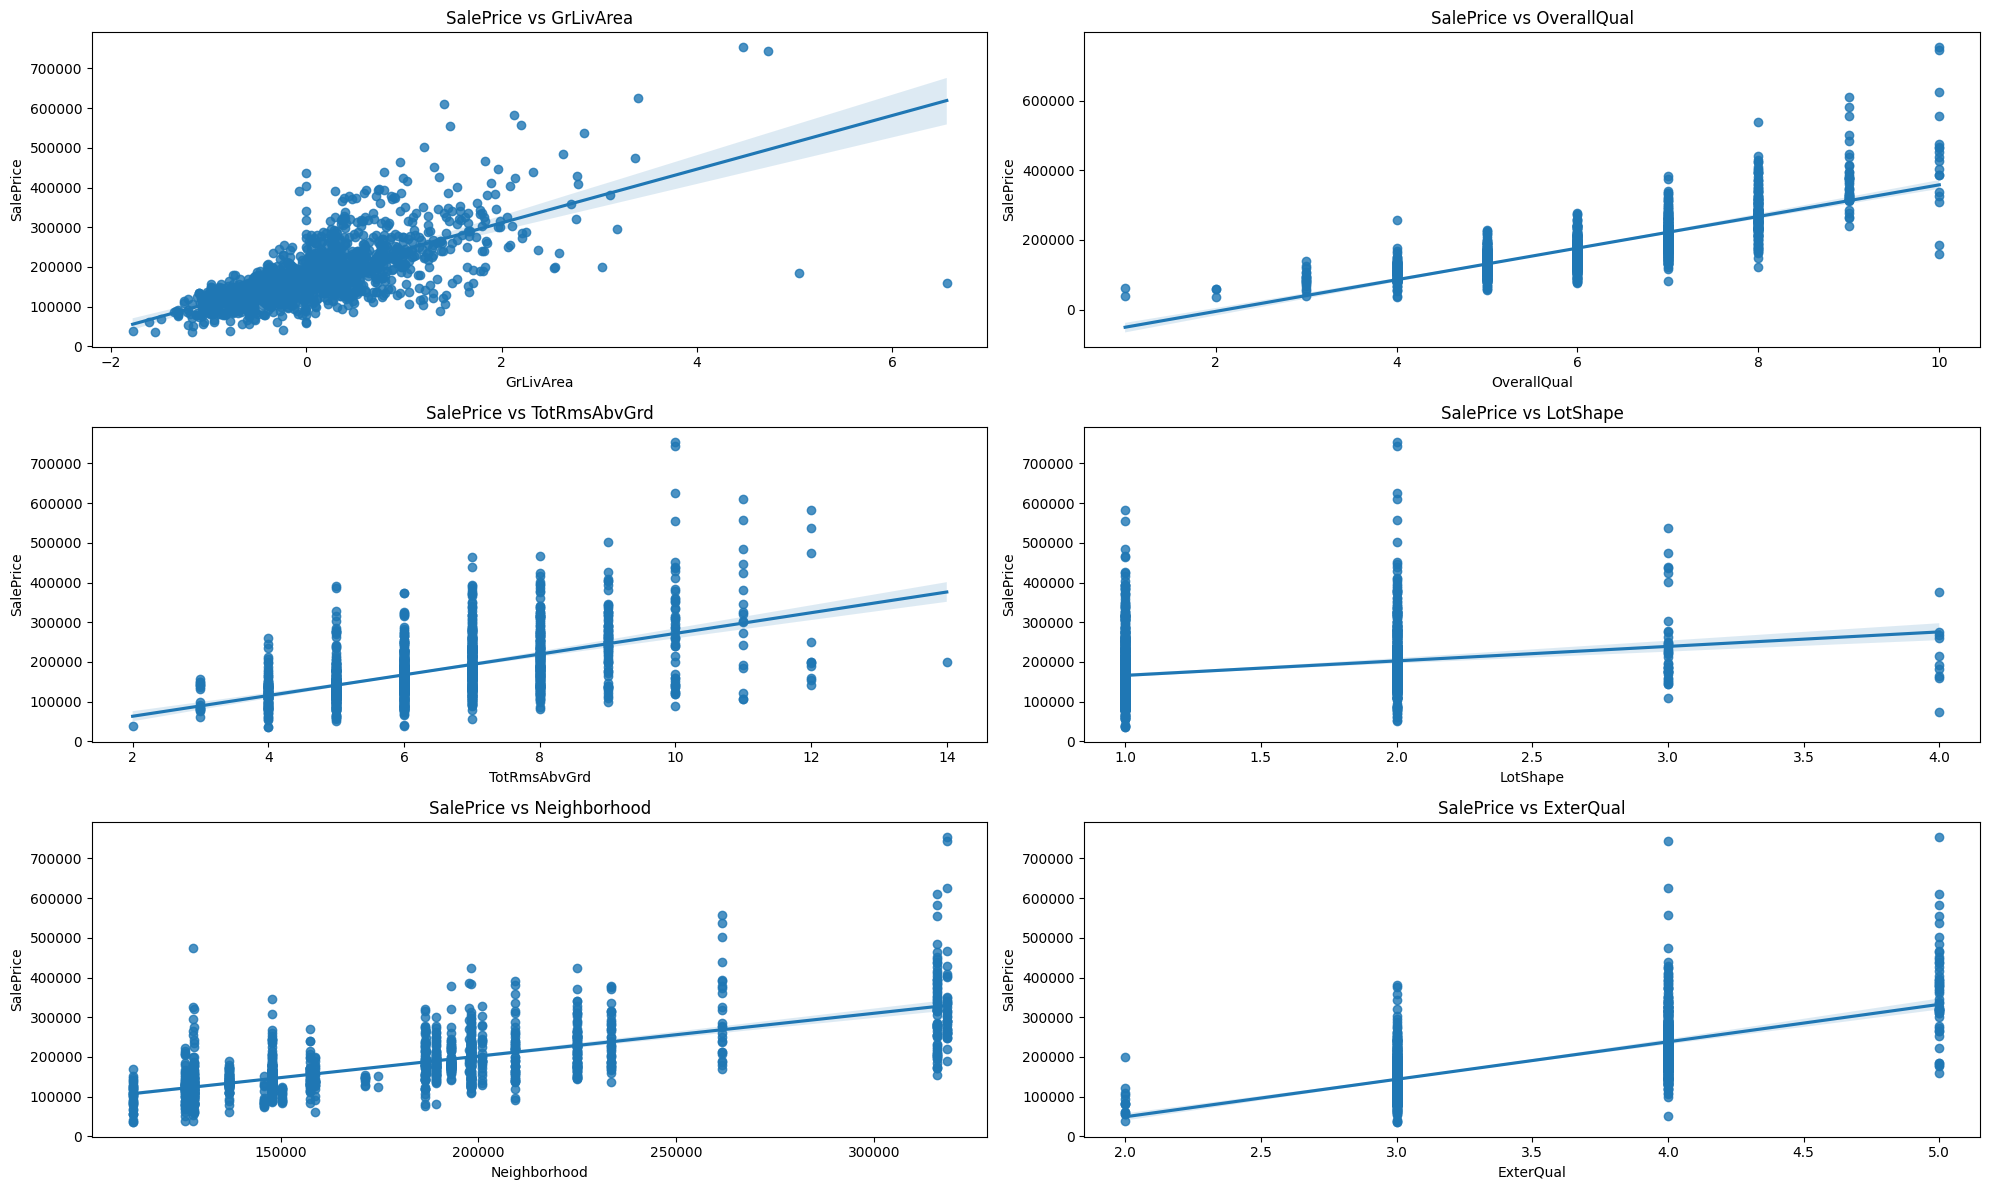

In [15]:
# Variables subset
independent_vars = ["GrLivArea", "OverallQual", "TotRmsAbvGrd", "LotShape", "Neighborhood", "ExterQual"]

fig, axs = plt.subplots(3, 2, figsize=(20, 12))

axs = axs.flatten()

# Loop to plot each variable vs SalePrice
for idx, var in enumerate(independent_vars):
    sns.regplot(x=X_prep_df[var], y=y, ax=axs[idx])
    axs[idx].set_title('SalePrice vs '+var)

plt.tight_layout()
plt.show()


From the plots above we see that:
- OverallQual: Houses with higher overall quality tend to have higher sale prices.
- GrLivArea: As the above-ground living area of a house increases, the sale price tends to increase. Since the data points are more centred around a smaller GrLivArea interval and less scattered around the regression line. we can not conclude that the relationship is linear.
- Neighborhood: Certain neighborhoods have higher sale prices compared to others.
- TotRmsAbvGrd: Houses with more rooms above ground tend to have higher sale prices.
- ExterQual: Higher quality exterior materials are associated with higher sale prices.

The linearity assumption seems to be more clear with OverallQual, TotRmsAbvGrd, Neighborhood and ExterQual. Since we can not conclude about linearity of releationship between LotShape and SalePrice. We might try a different approach to assess linearity and check the strength of the relationship between LotShape and SalePrice. 

Since LotShape is an ordinal variable where values are already encoded to numeric values as a result of our preprocessing steps, we need to use a statistical test that deals with integers such as Spearman coefficient.

In [16]:
# Convert your preprocessed data back to a DataFrame
X_prep_df = pd.DataFrame(X_prep, columns=cont_vars + num_ordi_var + cat_vars)

# Calculate the correlation
corr, _ = spearmanr(X_prep_df['LotShape'], y)
print('Spearmans correlation: %.3f' % corr)


Spearmans correlation: 0.734


The Spearman correlation of 0.734 suggests a fairly strong positive relationship between 'LotShape' and 'SalePrice'. That is, as the value of 'LotShape' increases, 'SalePrice' also tends to increase. 

To assess the linearity of the relationship between LotShape and SalePrice, we perform a linear regression by fitting a regression model where LotShape is the predictor and SalePrice is the independent variable. 

We then examine the statistical significance of the relationship by looking at measures like intercept and r-squared. Since 'LotShape' is an ordinal variable, the interpretation of the intercept in this case does not have practical significance, given that 'LotShape' can have ordinal values and can not be set to zero.

To make sure we do not base our regression analysis on the test data, we split X_prep into train and test and fit a linear regression model with one predictor (LotShaep) on the train data.

In [17]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_prep_df, y, test_size=0.2, random_state=42)

In [18]:
X_train_simple

,GrLivArea,OverallQual,TotRmsAbvGrd,LotShape,ExterQual,Neighborhood
254,-0.238619,5.0,5.0,147882.504251,1.0,3.0
1066,0.164835,6.0,7.0,193059.481445,2.0,4.0
638,-1.051805,5.0,4.0,128237.373454,1.0,3.0
799,0.474097,5.0,7.0,158661.871410,1.0,3.0
380,0.353218,5.0,6.0,158661.871410,1.0,3.0
...,...,...,...,...,...,...
1095,-0.238619,6.0,6.0,198086.306114,2.0,4.0
1130,0.808477,4.0,7.0,158661.871410,1.0,3.0
1294,-0.945055,5.0,5.0,128237.373454,1.0,3.0
860,-0.062794,7.0,7.0,209344.287867,1.0,4.0


In [22]:
# Fit a linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train_simple[['LotShape']], y_train_simple)

# Extract the coefficients and R-squared value
coefficient = regression_model.coef_[0]
intercept = regression_model.intercept_
y_predict = regression_model.predict(X_train_simple[['LotShape']])
r_squared = r2_score(y_train_simple, y_predict)


In [17]:
print('Coefficient:', coefficient)
print('Intercept:', intercept)
print('R-squared:', r_squared)

Coefficient: 1.0805027123053337
Intercept: -14286.400536713307
R-squared: 0.5224999504688278


The coefficient value of 1.0805 indicates that for each unit increase in 'LotShape', the predicted 'SalePrice' is expected to increase by approximately 1.0805. Since 'LotShape' is ordinal encoded as integers, this means that as the lot shape improves (higher integer values), there is a positive linear relationship with increasing 'SalePrice'.

The R-squared value of 0.5225 indicates that approximately 52.25% of the variance in 'SalePrice' can be explained by the linear relationship with 'LotShape'. This suggests that 'LotShape' alone accounts for a moderate amount of the variability in 'SalePrice'. However, it also implies that there is still a significant portion of the variability unexplained by the linear relationship with 'LotShape'.

Since the R-square error is smaller than 0.6, we can conclude that our model is mostly predicting incorrectly SalePrice. Next to R-square, we use a residual plot to get information over the error variance when it comes to our predicted SalePrice versus the actual SalePRice.

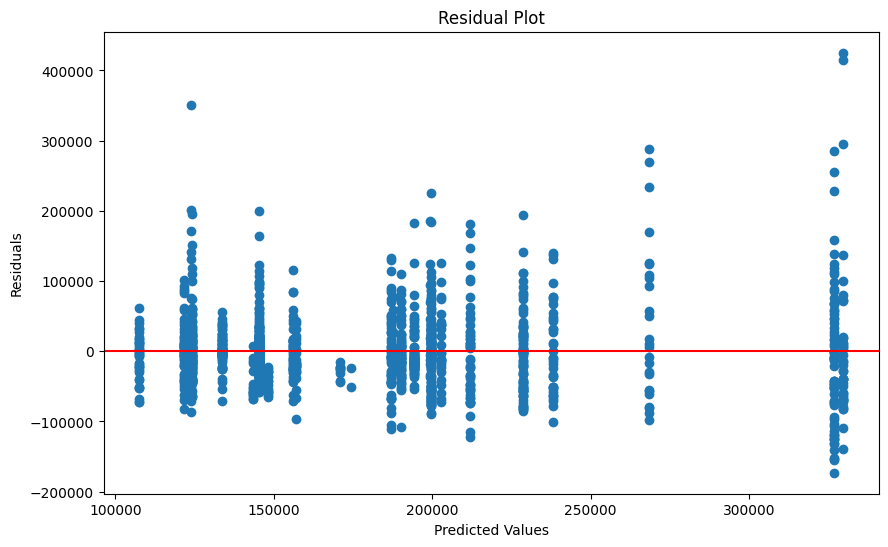

In [18]:
# 2. Compute the residuals
residuals = y - y_predict

# 3. Plot the residuals
plt.figure(figsize=(10,6))
plt.scatter(y_predict, residuals)
plt.axhline(y=0, color='r', linestyle='-') # This line represents where the residuals would be 0
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.show()

Indeed, the residual plot shows that the predicted values of SalePrice deviate widely from the actual saleprices.

Let's assess now linearity and the strength of relationship between SalePrice and all independent variables

In [25]:
# Variables subset
independent_vars = ["OverallQual", "TotRmsAbvGrd", "ExterQual", "GrLivArea", "Neighborhood", "LotShape"]

# Store the results in a list of dictionaries
results = []

# Assess linearity and strength of relationship for each variable
for var in independent_vars:

    regression_model.fit(X_train_simple[[var]], y_train_simple)

    coefficient = regression_model.coef_[0]
    intercept = regression_model.intercept_
    r_squared = r2_score(y_train_simple, regression_model.predict(X_train_simple[[var]]))

    # Spearman Correlation
    corr, _ = spearmanr(X_train_simple[var], y_train_simple)

    # Append the results to the list
    results.append({
        'Variable': var,
        'Coefficient': coefficient,
        'Intercept': intercept,
        'R-squared': r_squared,
        "Spearman's correlation": corr
    })

# Sort the results based on Spearman's correlation in descending order
results_sorted = sorted(results, key=lambda x: abs(x["Spearman's correlation"]), reverse=True)

# Print the results in a tabular format
header = "| {:13s} | {:13s} | {:12s} | {:11s} | {:24s} |".format(
    "Variable", "Coefficient", "Intercept", "R-squared", "Spearman's correlation"
)
print("+" + "-" * (len(header) - 2) + "+")
print(header)
print("+" + "-" * (len(header) - 2) + "+")
for result in results_sorted:
    line = "| {:13s} | {:13.4f} | {:12.4f} | {:11.4f} | {:24.4f} |".format(
        result['Variable'], result['Coefficient'], result['Intercept'], result['R-squared'],
        result["Spearman's correlation"]
    )
    print(line)
print("+" + "-" * (len(header) - 2) + "+")


+---------------------------------------------------------------------------------------+
| Variable      | Coefficient   | Intercept    | R-squared   | Spearman's correlation   |
+---------------------------------------------------------------------------------------+
| OverallQual   |    44379.8777 |  -90233.2229 |      0.6171 |                   0.8010 |
| LotShape      |        1.0369 |   -5675.5111 |      0.5058 |                   0.7263 |
| GrLivArea     |    64457.5610 |  175405.8796 |      0.4621 |                   0.7100 |
| Neighborhood  |    89520.9291 | -122454.4203 |      0.4429 |                   0.6648 |
| TotRmsAbvGrd  |    24823.6943 |   18557.3009 |      0.2708 |                   0.5208 |
| ExterQual     |    34052.8082 |  133044.5714 |      0.0677 |                   0.3072 |
+---------------------------------------------------------------------------------------+


reading the metrics from each independent variable from the results in the table above we see that:
- OverallQual: For each unit increase in the overall quality of a house, the predicted sale price increases by approximately $44,436. Houses with higher overall quality tend to have higher sale prices. The Spearman's correlation of 0.8098 suggests a strong positive relationship.

- LotShape: The Spearman's correlation rond 0.73 indicates a fairly strong positive relationship. Which validate our assumption about LotShape. 

- GrLivArea: As the above-ground living area of a house increases, the predicted sale price increases by approximately $64,457. There is a positive relationship between the living area and sale price. The Spearman's correlation of 0.7100 suggests a moderate positive relationship.

- Neighborhood: Certain neighborhoods have a significant impact on sale prices. The coefficient of $89,520 indicates that houses located in certain neighborhoods tend to have higher sale prices. The Spearman's correlation of 0.66 suggests a moderate positive relationship.

- TotRmsAbvGrd: For each unit increase in the number of rooms above ground, the predicted sale price increases by approximately $24,823. There is a positive relationship between the number of rooms and sale price. The Spearman's correlation of 0.52 indicates a moderate positive relationship.

- ExterQual: Higher quality exterior materials are associated with lower sale prices. For each unit increase in the exterior quality, the predicted sale price decreases by approximately $34,052. The Spearman's correlation of 0.3072 suggests a weekpostivive relationship.

As a conclusion, OverallQual, LotShape, GrLivArea, Neighborhood, and TotRmsAbvGrd show a linear relationship with SalePrice, while ExterQual shows a moderate negative relationship. 

#### 3.2 Linear regression with multiple predictors
In regression analysis, it is also possible to use more than predictor to explain and predict variance in the target variable. Sometimes the regression model is even better performing when provided with multiple predictors. The challenge is actually to find the best set of predictors that contribute the best to the regression model performance.
That is what we are doing in this part. 

In [26]:
sfs1 = sfs(regression_model, k_features=5, forward=True, verbose=1, scoring='r2')
sfs1.fit(X_train_simple, y_train_simple)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
Features: 1/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
Features: 2/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
Features: 3/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/5[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 5/5

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(5, 5),
                          scoring='r2', verbose=1)

In [27]:
subsets_dict = sfs1.subsets_
print(subsets_dict)

{1: {'feature_idx': (1,), 'cv_scores': array([0.61269998, 0.61201878, 0.62438352, 0.61428784, 0.60480051]), 'avg_score': 0.6136381243905563, 'feature_names': ('OverallQual',)}, 2: {'feature_idx': (0, 1), 'cv_scores': array([0.73039734, 0.61715358, 0.65242679, 0.72009021, 0.74233433]), 'avg_score': 0.692480449858695, 'feature_names': ('GrLivArea', 'OverallQual')}, 3: {'feature_idx': (0, 1, 3), 'cv_scores': array([0.77155156, 0.69472999, 0.72830022, 0.76833498, 0.77850057]), 'avg_score': 0.7482834638419446, 'feature_names': ('GrLivArea', 'OverallQual', 'LotShape')}, 4: {'feature_idx': (0, 1, 3, 5), 'cv_scores': array([0.77720619, 0.70481025, 0.73333281, 0.76696687, 0.79727493]), 'avg_score': 0.7559182104674077, 'feature_names': ('GrLivArea', 'OverallQual', 'LotShape', 'Neighborhood')}, 5: {'feature_idx': (0, 1, 3, 4, 5), 'cv_scores': array([0.77961182, 0.71455402, 0.72448263, 0.77114627, 0.79947966]), 'avg_score': 0.757854881488667, 'feature_names': ('GrLivArea', 'OverallQual', 'LotShape

In [28]:
def plot_sfs_results(subsets_dict):
    # Create lists to store the number of features, feature names and the corresponding avg_score
    num_features = []
    feature_names = []
    avg_scores = []

    # Iterate over the subsets_dict
    for subset in subsets_dict.values():
        num_features.append(len(subset['feature_names']))
        feature_names.append(', '.join(subset['feature_names']))
        avg_scores.append(subset['avg_score'])

    # Create a DataFrame from the lists
    results_df = pd.DataFrame({
        'Number of Features': num_features,
        'Features': feature_names,
        'Average Score': avg_scores
    })

    # Display the DataFrame
    display(results_df)

    # Plot avg_scores vs num_features
    plt.figure(figsize=(10,6))
    plt.plot(num_features, avg_scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Average Score (R^2)')
    plt.title('Sequential Feature Selection Results')
    plt.grid(True)
    plt.show()



,Number of Features,Features,Average Score
0,1,OverallQual,0.624610
1,2,"GrLivArea, OverallQual",0.705044
2,3,"GrLivArea, OverallQual, LotShape",0.760585
3,4,"GrLivArea, OverallQual, LotShape, Neighborhood",0.767312
4,5,"GrLivArea, OverallQual, LotShape, ExterQual, N...",0.769588


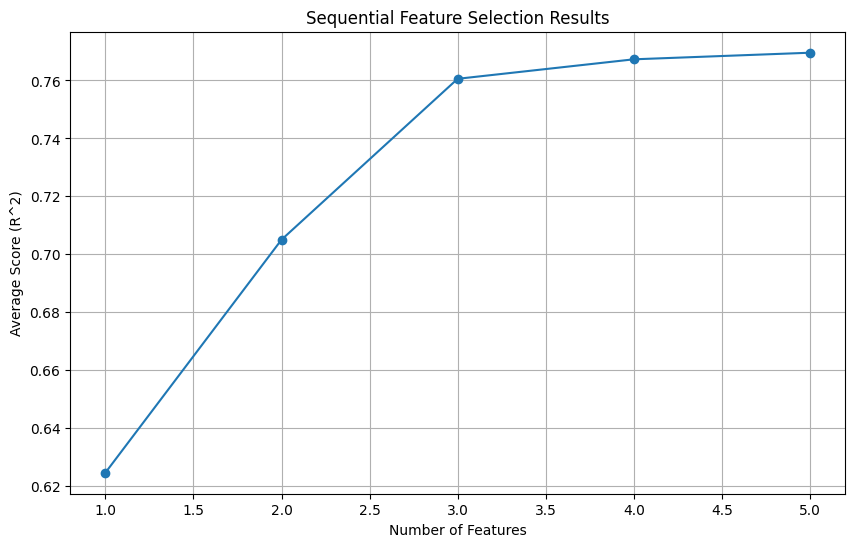

In [23]:
plot_sfs_results(subsets_dict)

Looking at the plot above, we see that the R-squared increments as we increase the number of predictors used to predict SalePrice by our linear model. 
The model performs best when 3 predictors are used ('GrLivArea', 'OverallQual' and 'LotShape') and since even including 'Neighborhood' to the model improves slightly the R^2, we conclude that 'GrLivArea', 'OverallQual' and 'LotShape', combined in a linear regression model, predicts the best SalePrice.

#### 3.3 Tuning the regression model 

Note that we have used the linear regression using data that has been pre-processed following one single senario:
- Ordinal variable encoded as strings (“LotShape” and "ExterQual") are encoded with ordinal encoding
- Nominal variable encoded as strings like ("Neighborhood") is encoded with target encoding
- Only the continuous variable(GrLivArea) is scaled with the Robust scaler.

Now the question is "does the regression model perform better with other preprocessing aproaches", for instance "One-Hot encoding" for nominal variables.

Let's separate the dependent and the independent variables and split the dataset into train and test set. By this we make sure that the test set remains unseen during model hyperparameter tuning.

In [24]:
y = ames_housing_subset['SalePrice']
X = ames_housing_subset.drop(columns='SalePrice')
X

,GrLivArea,LotShape,ExterQual,OverallQual,Neighborhood,TotRmsAbvGrd
0,1710.0,Reg,Gd,7,CollgCr,8
1,1262.0,Reg,TA,6,Veenker,6
2,1786.0,IR1,Gd,7,CollgCr,6
3,1717.0,IR1,TA,7,Crawfor,7
4,2198.0,IR1,Gd,8,NoRidge,9
...,...,...,...,...,...,...
1455,1647.0,Reg,TA,6,Gilbert,7
1456,2073.0,Reg,TA,6,NWAmes,7
1457,2340.0,Reg,Ex,7,Crawfor,9
1458,1078.0,Reg,TA,5,NAmes,5


In [25]:
# Split the data into train and test sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Define the strategies for imputation

imputation_strategies = {
    'cont_vars': 'median',
    'num_ordi_var': 'most_frequent',
    'categorical_onehot': 'most_frequent',
    'categorical_ordinal': 'most_frequent'
}

# Define a function for log transformation
def log_transform(X_train):
    return np.log1p(X_train)

# Update the preprocessors for the continuous variables to include log transformation
cont_var_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=imputation_strategies['cont_vars'])),
    ('log_transform', FunctionTransformer(log_transform)),
    ('scaler', RobustScaler())
])

new_num_ord_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=imputation_strategies['num_ordi_var']))
])

new_onehot_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=imputation_strategies['categorical_onehot'])),
    ('onehot_enc', OneHotEncoder(handle_unknown='ignore'))
])

new_ordinal_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=imputation_strategies['categorical_ordinal'])),
    ('ordinal_enc', OrdinalEncoder(col_mapping={
        'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
        'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    }))
])


In [27]:
# We'll use ColumnTransformer to put together these preprocessing steps for different columns
grid_preprocessor = ColumnTransformer(
    transformers=[
        ('continuous_vars', cont_var_pipeline, cont_vars),
        ('numerical_ordinal_vars', new_num_ord_preprocessor, num_ordi_var),
        ('categorical_ordinal', new_ordinal_encoder, ['LotShape', 'ExterQual']),
        ('categorical_onehot', new_onehot_encoder, ['Neighborhood']),
    ])

In [28]:

final_pipeline = Pipeline(steps=[
    ('preprocessor', grid_preprocessor),
    ('regressor', LinearRegression())  # default model
])

In [29]:
# Update param_grid accordingly

param_grid = [
    {
        'preprocessor__continuous_vars__imputer__strategy': [imputation_strategies['cont_vars']],
        'preprocessor__numerical_ordinal_vars__imputer__strategy': [imputation_strategies['num_ordi_var']],
        'preprocessor__categorical_onehot__imputer__strategy': [imputation_strategies['categorical_onehot']],
        'preprocessor__categorical_ordinal__ordinal_enc__col_mapping': [
            {'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}
        ],
        'regressor': [LinearRegression()]
    },
    # Rest of the parameter grid
]

In [30]:
grid_search = GridSearchCV(estimator=final_pipeline, param_grid=param_grid, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous_vars',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000017D7408DD30>)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['GrLivArea']),
                                                                        ('numerical_ordinal_vars',
                                                                         P...
             param_grid=[{'preprocessor__categorical_onehot__imputer__strategy': ['most_frequent'],
                          'preprocessor__categorical_ordinal__ordinal_enc__col_mapping': [{'ExterQual': {'Ex': 5,
                                                                                                         'Fa': 2,
                                                                                                         'Gd': 4,
                                                                                                         'Po': 1,
                                                                                                         'TA': 3},
                                                                                           'LotShape': {'IR1': 2,
                                                                                                        'IR2': 3,
                                                                                                        'IR3': 4,
                                                                                                        'Reg': 1}}],
                          'preprocessor__continuous_vars__imputer__strategy': ['median'],
                          'preprocessor__numerical_ordinal_vars__imputer__strategy': ['most_frequent'],
                          'regressor': [LinearRegression()]}])

In [31]:
grid_search.best_score_

0.7549967315253598

In [32]:
grid_search.cv_results_

{'mean_fit_time': array([0.03081408]),
 'std_fit_time': array([0.00290326]),
 'mean_score_time': array([0.01420465]),
 'std_score_time': array([0.00174869]),
 'param_preprocessor__categorical_onehot__imputer__strategy': masked_array(data=['most_frequent'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_preprocessor__categorical_ordinal__ordinal_enc__col_mapping': masked_array(data=[{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_preprocessor__continuous_vars__imputer__strategy': masked_array(data=['median'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_preprocessor__numerical_ordinal_vars__imputer__strategy': masked_array(data=['most_frequent'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_regressor': maske

the best performing parameter combination has a rank of 1 and a mean test score of approximately 0.743.

In [33]:
results = grid_search.cv_results_

for mean_score, params in zip(results['mean_test_score'], results['params']):
    print("Mean Score:", mean_score)
    print("Parameters:", params)
    print("--------------")

Mean Score: 0.7549967315253598
Parameters: {'preprocessor__categorical_onehot__imputer__strategy': 'most_frequent', 'preprocessor__categorical_ordinal__ordinal_enc__col_mapping': {'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, 'preprocessor__continuous_vars__imputer__strategy': 'median', 'preprocessor__numerical_ordinal_vars__imputer__strategy': 'most_frequent', 'regressor': LinearRegression()}
--------------


In [34]:
X_train_t, X_eval_t, y_train_t, y_eval_t = train_test_split(X, y, test_size=0.2, random_state=42)

In addition to Linear regression, we want also to test our preprocessed data with other regression models like Lasso and Ridge.

I specified multiple options for the strategy parameter of the SimpleImputer used in the preprocessor pipeline for each type of variable in full_param_grid. GridSearchCV will then generate combinations of these parameters to find the best performing model according to the specified cross-validation strategy (in my case, 5-fold cross-validation).

In [38]:
full_param_grid = [
        {
        'preprocessor__continuous_vars__imputer__strategy': ['mean', 'median'],
        'preprocessor__numerical_ordinal_vars__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'preprocessor__categorical_onehot__imputer__strategy': ['constant', 'most_frequent'],
        'preprocessor__categorical_ordinal__ordinal_enc__col_mapping': [
            {'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}
        ],
        
        'regressor': [LinearRegression()]
    },
    {
        'preprocessor__continuous_vars__imputer__strategy': ['mean', 'median'],
        'preprocessor__numerical_ordinal_vars__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'preprocessor__categorical_onehot__imputer__strategy': ['constant', 'most_frequent'],
        'preprocessor__categorical_ordinal__ordinal_enc__col_mapping': [
            {'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}
        ],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 0.5, 1.0]
    },
    {
        'preprocessor__continuous_vars__imputer__strategy': ['mean', 'median'],
        'preprocessor__numerical_ordinal_vars__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'preprocessor__categorical_onehot__imputer__strategy': ['constant', 'most_frequent'],
        'preprocessor__categorical_ordinal__ordinal_enc__col_mapping': [
            {'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}
        ],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 0.5, 1.0]
    }
]


In [39]:
full_grid_search = GridSearchCV(estimator=final_pipeline, param_grid=full_param_grid, cv=5, error_score='raise')
full_grid_search.fit(X_train_t,y_train_t)

c:\Users\lamaakchaoui.c\Anaconda3\envs\pycaret_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161887302399.28357, tolerance: 537415025.1745832
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\lamaakchaoui.c\Anaconda3\envs\pycaret_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161565595200.65417, tolerance: 572016182.2224231
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\lamaakchaoui.c\Anaconda3\envs\pycaret_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196650205830.4889, tolerance: 525605188.80204767
  model = cd_fast.sparse_enet_coordinate_descent(
c:\User

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous_vars',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000017D7408DD30>)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['GrLivArea']),
                                                                        ('numerical_ordinal_vars',
                                                                         P...
                          'preprocessor__categorical_ordinal__ordinal_enc__col_mapping': [{'ExterQual': {'Ex': 5,
                                                                                                         'Fa': 2,
                                                                                                         'Gd': 4,
                                                                                                         'Po': 1,
                                                                                                         'TA': 3},
                                                                                           'LotShape': {'IR1': 2,
                                                                                                        'IR2': 3,
                                                                                                        'IR3': 4,
                                                                                                        'Reg': 1}}],
                          'preprocessor__continuous_vars__imputer__strategy': ['mean',
                                                                               'median'],
                          'preprocessor__numerical_ordinal_vars__imputer__strategy': ['mean',
                                                                                      'median',
                                                                                      'most_frequent'],
                          'regressor': [Ridge()],
                          'regressor__alpha': [0.1, 0.5, 1.0]}])

In [40]:
full_grid_search.cv_results_

{'mean_fit_time': array([0.04835958, 0.03082995, 0.13162122, 0.0371058 , 0.02780313,
        0.02677813, 0.0283988 , 0.02719994, 0.02720308, 0.02695484,
        0.02907796, 0.02720623, 0.11952338, 0.10179682, 0.07805004,
        0.10416985, 0.10236602, 0.07570934, 0.1038177 , 0.10074778,
        0.08287559, 0.11662507, 0.12013884, 0.0772398 , 0.10351095,
        0.10019403, 0.07707663, 0.10903568, 0.10432525, 0.07753229,
        0.10344729, 0.10566444, 0.10546942, 0.09869547, 0.09647484,
        0.09009962, 0.10213161, 0.09981065, 0.08942027, 0.09922638,
        0.0979743 , 0.10002294, 0.1081985 , 0.10056539, 0.09255538,
        0.10337615, 0.09764705, 0.09150615, 0.02452669, 0.02316666,
        0.02253857, 0.02352319, 0.02505689, 0.02433553, 0.03722529,
        0.03039398, 0.02916927, 0.03243756, 0.0275023 , 0.02310929,
        0.02435255, 0.03605928, 0.0281322 , 0.02387395, 0.02421708,
        0.02299929, 0.02339444, 0.02379107, 0.02340112, 0.03235264,
        0.0252017 , 0.02502236,

To better present the output of full_grid_search.cv_results_ and understand the results, we save it to a pandas dataframe where the results of cross-validation are stored.

In [41]:
# Extract results
cv_results = full_grid_search.cv_results_

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Display DataFrame
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__categorical_onehot__imputer__strategy,param_preprocessor__categorical_ordinal__ordinal_enc__col_mapping,param_preprocessor__continuous_vars__imputer__strategy,param_preprocessor__numerical_ordinal_vars__imputer__strategy,param_regressor,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048360,0.037673,0.014116,0.001449,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",mean,mean,LinearRegression(),NaN,{'preprocessor__categorical_onehot__imputer__s...,0.762493,0.730110,0.743348,0.743240,0.792130,0.754264,0.021567,64
1,0.030830,0.003405,0.013678,0.002017,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",mean,median,LinearRegression(),NaN,{'preprocessor__categorical_onehot__imputer__s...,0.762493,0.730110,0.743348,0.743240,0.792130,0.754264,0.021567,64
2,0.131621,0.205255,0.011403,0.000504,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",mean,most_frequent,LinearRegression(),NaN,{'preprocessor__categorical_onehot__imputer__s...,0.762493,0.730110,0.743348,0.743240,0.792130,0.754264,0.021567,64
3,0.037106,0.015814,0.014590,0.003262,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,mean,LinearRegression(),NaN,{'preprocessor__categorical_onehot__imputer__s...,0.762069,0.729476,0.743730,0.743261,0.792005,0.754108,0.021595,79
4,0.027803,0.001929,0.011202,0.001168,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,median,LinearRegression(),NaN,{'preprocessor__categorical_onehot__imputer__s...,0.762069,0.729476,0.743730,0.743261,0.792005,0.754108,0.021595,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.022808,0.001724,0.010389,0.000790,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,median,Ridge(),0.5,{'preprocessor__categorical_onehot__imputer__s...,0.762073,0.733062,0.743975,0.744275,0.793359,0.755349,0.021160,10
80,0.021414,0.000510,0.010801,0.000418,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,median,Ridge(),1.0,{'preprocessor__categorical_onehot__imputer__s...,0.762300,0.733156,0.743311,0.745237,0.793586,0.755518,0.021213,4
81,0.022606,0.000807,0.010602,0.000479,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,most_frequent,Ridge(),0.1,{'preprocessor__categorical_onehot__imputer__s...,0.761774,0.732983,0.744401,0.743244,0.792979,0.755076,0.021088,28
82,0.023196,0.000414,0.009600,0.000799,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,most_frequent,Ridge(),0.5,{'preprocessor__categorical_onehot__imputer__s...,0.762073,0.733062,0.743975,0.744275,0.793359,0.755349,0.021160,10


To get the model providing the best results and the best preprocessing steps combination I sort the dataframe on the mean_test_score.

In [42]:
# Sort DataFrame by mean test score
cv_results_df_sorted = cv_results_df.sort_values(by='mean_test_score', ascending=False)

# Display sorted DataFrame
cv_results_df_sorted


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__categorical_onehot__imputer__strategy,param_preprocessor__categorical_ordinal__ordinal_enc__col_mapping,param_preprocessor__continuous_vars__imputer__strategy,param_preprocessor__numerical_ordinal_vars__imputer__strategy,param_regressor,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
68,0.023401,0.001844,0.012593,0.005715,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",mean,mean,Ridge(),1.0,{'preprocessor__categorical_onehot__imputer__s...,0.762719,0.733786,0.742899,0.745245,0.793700,0.755670,0.021198,1
71,0.025022,0.002618,0.012002,0.001657,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",mean,median,Ridge(),1.0,{'preprocessor__categorical_onehot__imputer__s...,0.762719,0.733786,0.742899,0.745245,0.793700,0.755670,0.021198,1
74,0.022198,0.000747,0.010206,0.000401,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",mean,most_frequent,Ridge(),1.0,{'preprocessor__categorical_onehot__imputer__s...,0.762719,0.733786,0.742899,0.745245,0.793700,0.755670,0.021198,1
83,0.022420,0.001013,0.009809,0.000707,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,most_frequent,Ridge(),1.0,{'preprocessor__categorical_onehot__imputer__s...,0.762300,0.733156,0.743311,0.745237,0.793586,0.755518,0.021213,4
80,0.021414,0.000510,0.010801,0.000418,most_frequent,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,median,Ridge(),1.0,{'preprocessor__categorical_onehot__imputer__s...,0.762300,0.733156,0.743311,0.745237,0.793586,0.755518,0.021213,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.027803,0.001929,0.011202,0.001168,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,median,LinearRegression(),NaN,{'preprocessor__categorical_onehot__imputer__s...,0.762069,0.729476,0.743730,0.743261,0.792005,0.754108,0.021595,79
3,0.037106,0.015814,0.014590,0.003262,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,mean,LinearRegression(),NaN,{'preprocessor__categorical_onehot__imputer__s...,0.762069,0.729476,0.743730,0.743261,0.792005,0.754108,0.021595,79
21,0.116625,0.013003,0.015388,0.006189,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,mean,Lasso(),0.1,{'preprocessor__categorical_onehot__imputer__s...,0.762070,0.729476,0.743728,0.743199,0.792002,0.754095,0.021600,82
24,0.103511,0.002213,0.011086,0.001117,constant,"{'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'I...",median,median,Lasso(),0.1,{'preprocessor__categorical_onehot__imputer__s...,0.762070,0.729476,0.743728,0.743199,0.792002,0.754095,0.021600,82


Based on the rank_test_score column, the configurations that used a Ridge regression model with an alpha of 1.0, a mean strategy for continuous variable imputation, and a mean/median strategy for numerical ordinal variable imputation performed the best with a mean_test_score=0.755670. 

Now that we know from the grid search the best preprocessing steps combination, we can use them to transform X. We define a new pipeline with this time the optimal steps based on the previous results.
First we split our data into train and test data. We then use our defined model with tr

In [43]:
# Create your optimal preprocessing pipeline based on the results
optimal_preprocessing = ColumnTransformer(
    transformers=[
        ('continuous_vars', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # determined as optimal
            ('log_transform', FunctionTransformer(log_transform)),
            ('scaler', RobustScaler())
        ]), cont_vars),
        ('numerical_ordinal_vars', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))  # determined as optimal
        ]), num_ordi_var),
        ('categorical_ordinal', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # determined as optimal
            ('ordinal_enc', OrdinalEncoder(col_mapping={
                'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
                'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
            }))
        ]), ['LotShape', 'ExterQual']),
        ('categorical_onehot', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # determined as optimal
            ('onehot_enc', OneHotEncoder(handle_unknown='ignore'))
        ]), ['Neighborhood']),
    ])

# Apply the transformation to X
X_train_transformed = optimal_preprocessing.fit_transform(X_train_t)


In [44]:
X_train_transformed.shape

(1168, 30)

You probably are not able to print the content of X_transformed and might get a message (<1460x30 sparse matrix of type '<class 'numpy.float64'>'). This is because the transformed dataframe is stored as a sparse matrix to optimize memory usage, since the dimension of the returned matrix is highly increased (30 columns) due to One Hot encoding.

In [45]:
X_train_transformed

<1168x30 sparse matrix of type '<class 'numpy.float64'>'
	with 7008 stored elements in Compressed Sparse Row format>

In [46]:
X_train.shape

(1168, 6)

In [47]:
# Transform the evaluation set using the preprocessor
X_eval_transformed = optimal_preprocessing.transform(X_eval)


In [48]:
X_eval_transformed

<292x30 sparse matrix of type '<class 'numpy.float64'>'
	with 1752 stored elements in Compressed Sparse Row format>

In [49]:
# Make predictions using the best model
y_pred = grid_search.best_estimator_.predict(X_eval)

In [50]:
y_pred

array([146820.45287063, 335679.44809322,  95571.24574211, 168471.4499237 ,
       276189.76331676,  55466.84438108, 251175.88376972, 156199.2664648 ,
        55466.84438108, 141897.6370959 , 162846.71708841, 114647.43697236,
        36168.25220929, 272788.86918301, 166121.01551266, 120428.04976115,
       212797.94860839, 127464.94251345, 120306.6037723 , 219923.476477  ,
       165419.1286173 , 235902.00171165, 192878.13772531, 109351.16112985,
       214626.97579461, 167155.67387863, 194553.4612031 ,  77372.14297079,
       170580.02398533, 203543.5267878 , 133058.09922104, 285707.68686988,
       247016.04232973,  98600.42390314, 251836.59583524, 143588.97346285,
       161757.4450359 , 231512.6894517 , 336632.45850882,  83095.84977817,
       144404.40920565, 237832.00666877, 121143.29860429, 323635.66178903,
       127080.76561814, 170628.32733049, 118704.74504011, 120795.8599079 ,
       383560.73717722, 148452.58688863, 119230.80359845, 176454.96953398,
       121589.49307003, 3

In [51]:
# Compute metrics
mse = mean_squared_error(y_eval, y_pred)
mae = mean_absolute_error(y_eval, y_pred)
r2 = r2_score(y_eval, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error (MSE): 1591611070.6035972
Mean Absolute Error (MAE): 24954.257593584207
R2 Score: 0.7924976034119317


Since the average of the squared differences between the actual and predicted values is approximately 1,591,611,070.6, that suggests that the model is making quite large errors. The MAE of $24,954.26 means that, on average, our model's predictions deviate by this amount from the actual prices. While the coefficient of determination is around 0.79 suggests that about 79% of the variability in SalePrice is explained by our model.

#### 3.4 Which other regression models can be more efficient than linear regression for our dataset? 

As testing multiple regression models with our data to answer this question might be a tough task in terms of computation power and time. I choose to use pycaret to test perform a model selection with my data. 

Regressions models compared in this notebook are: Linear Regression ('lr'), Linear Regression ('lr'), Linear Regression ('lr'), AdaBoost Regressor, AdaBoost Regressor 

For the Pycaret implementation, I use the not yet prepared dataset, since pycaret has already a preprocessing pipeline.

PS: As PyCaret is more suitable to work from Jupyter Notebook, it is needed in case the notebook is run on Pycharm or Visual Studio code to call the pull() function to display the comparison output table. As without that line of code, only the name of the best model will be displayed.

In [52]:
# import regression module
from pycaret.regression import *

# setup the environment 
s = setup(data = ames_housing_subset, target = 'SalePrice', session_id=123)

# compare all models
best_model_pycaret = compare_models(n_select=5, include=['lr', 'rf', 'gbr', 'ada', 'lasso'])

regression_results = pull()
print(regression_results)


,Description,Value
0,Session id,123
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 7)"
4,Transformed data shape,"(1460, 37)"
5,Transformed train set shape,"(1021, 37)"
6,Transformed test set shape,"(439, 37)"
7,Numeric features,3
8,Categorical features,3
9,Rows with missing values,2.5%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,23691.5284,1253719146.8235,34842.9845,0.8062,0.1780,0.1392,0.2090
rf,Random Forest Regressor,24281.5676,1500574008.6337,37925.2427,0.7740,0.1843,0.1410,0.2880
lr,Linear Regression,24725.8808,1510665617.9722,38179.6644,0.7716,0.1976,0.1445,0.8620
lasso,Lasso Regression,24716.0410,1510040800.9914,38172.3606,0.7716,0.1975,0.1444,0.0990
ada,AdaBoost Regressor,29585.8097,1775072562.5142,41500.0815,0.7295,0.2320,0.1930,0.1910


                             Model         MAE           MSE        RMSE  \
gbr    Gradient Boosting Regressor  23691.5284  1.253719e+09  34842.9845   
rf         Random Forest Regressor  24281.5676  1.500574e+09  37925.2427   
lr               Linear Regression  24725.8808  1.510666e+09  38179.6644   
lasso             Lasso Regression  24716.0410  1.510041e+09  38172.3606   
ada             AdaBoost Regressor  29585.8097  1.775073e+09  41500.0815   

           R2   RMSLE    MAPE  TT (Sec)  
gbr    0.8062  0.1780  0.1392     0.209  
rf     0.7740  0.1843  0.1410     0.288  
lr     0.7716  0.1976  0.1445     0.862  
lasso  0.7716  0.1975  0.1444     0.099  
ada    0.7295  0.2320  0.1930     0.191  


From the regression analysis steps we followed, we come to the conclusion of the following:
- The linear model with OverallQual as the predictor has an R-squared value of 0.58. This suggests that 58% of the variation in the dependent variable (SalePrice) can be explained by OverallQual.

- Adding Neighborhood to the model increases the R-squared value to 0.64. This means that together, OverallQual and Neighborhood can explain 64% of the variation in SalePrice. The addition of Neighborhood to the model has therefore improved the model's explanatory power.

- The Sequential Feature Selector (SFS) indicates that the best linear model (in terms of R-squared) involves the predictors GrLivArea, OverallQual, and Neighborhood. This suggests that this combination of predictors provides a better explanation of the variation in SalePrice than either OverallQual alone or OverallQual and Neighborhood together.

- Training other models next to linear regression with the data shows that Gradient Boosting Regressor is the best model with an R-squared of 0.81. This suggests that, of all 5 models compared, the Gradient Boosting Regressor can explain the highest proportion (approximately 81%) of the variation in SalePrice.

- The fact that the Gradient Boosting Regressor outperforms all the linear models suggests that the relationship between SalePrice and its predictors may be non-linear and/or involve interactions between predictors. 